# ASTR 596 Fall 2023 - Surface photometry lab (50 Points)
In this lab we will be performing surface photometry of two nearby galaxies, an elliptical and a spiral.  

This lab will be done via a mixture of python commands using the photutils aperture photometry package (https://photutils.readthedocs.io/en/stable/aperture.html) and the photutils isophote fitting package (https://photutils.readthedocs.io/en/stable/isophote.html).  We will also be using imexam and ds9.

In this lab you will learn how to do the following things:
* estimate the background for an image and subtract it;
* estimate initial guesses for input parameters to an isophotal fitting code using ds9;
* fit elliptical isophotes;
* use photometry within these isophotes to measure the radial profile of various parameters;
* compute the radius within which half the total light is contained.  This is called the effective radius.

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on <font color='red'>11/20 at Noon</font>** to be handed into the "Surface Photometry" assignment in <font color='red'>Module 7</font>.

You will need to download the raw data from https://www.dropbox.com/t/9JMlIMfRblkfGiAY.  There are four galaxy images.  You will need to measure something from all of them.  The galaxies are:
* NGC 3982
* NGC 5198
* NGC 5985
* PCG 0997820

I suggest you make a directory on your computer called `~/ASTR596/Data` and put data in there in a directory you name that is specific to this assignment.  

In [379]:
#import 
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors


from astropy.nddata import CCDData
#from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project

### Some functions to display the images and overplot the stars

In [380]:
def imdisplay(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    if (logscale):
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        
    cbar = fig.colorbar(im, ax=ax, fraction=0.04)
    cbar.ax.set_ylabel('counts')
    return fig,ax
    #fig.colorbar(fraction=.08)

In [381]:
#***************
#put your data directory here
datadir = '/home/c413a612/ASTR596/Data/Surface_Photometry/Surface_Photometry'
os.chdir(datadir)

## Display the image in DS9

SAOimage DS9 is a popular and easy to use image viewer.  There are various tutorials at https://sites.google.com/cfa.harvard.edu/saoimageds9/documentation?authuser=0 .

Here is another third party tutorial https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/ 

In the following description I will refer to menu choices as those at the top of the screen or window.  I will refer to buttons as the double line of buttons right above where the image is displayed.  I will refer to sub buttons with **button1**->**button2**

1. In DS9 open `NGC3982-custom-image-r.fits`
2. Under the **scale** button choose **log** and **zscale**.  In the Menu bar choose Scale->Scale parameters.  In the "high" box choose 3.
3. Use the right mouse button to change the stretch on the image.  You may need to select the **edit**->**none** or **edit**->**colorbar** button for this to work.


## Problem 1 - Estimate the background and subtract it (5 Points)

Before performing photometry you need to subtract off the background.  To do this for this exercise you are going to:
1. pick a square region in each of the 4 corners of the image and compute the best estimate of the background level over all the pixels in these areas.  Note that the straight average may not be the best option.
2. subtract this background level from the image 
3. display the background subtracted image

#### 1. compute background level
Here is an example of how to display an image with a log scaling.

10.19071102142334 11.842433891296398


Text(0.5, 1.0, 'NGC3982-custom-image-r.bkg.fits')

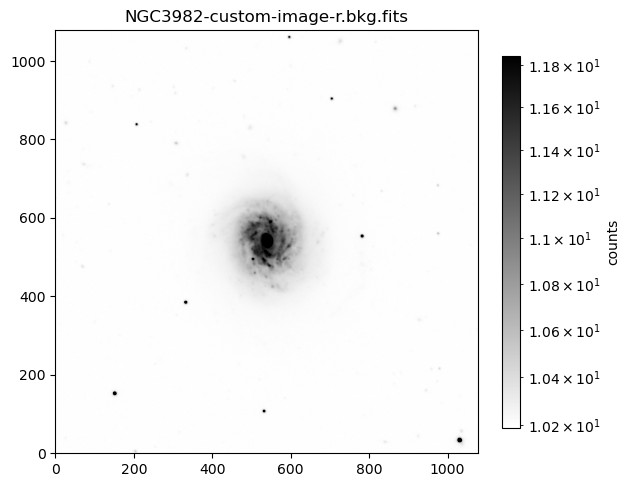

In [382]:
imname = 'NGC3982-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))
data,header = fits.getdata(imname, header=True)
imdisplay(data,v1perc=1,v2perc=99.9,logscale=True)

plt.title(imname)

This is a code that will take in an image name and data, as well as corners of background boxes, and will measure the background in two different ways.

In [383]:
def background_meas(imname,data,header,fig,ax,corners,bkg_size=5):
    #need to find ways to select regions of pixels in image
    imdisplay(data,v1perc=1,v2perc=99,logscale=True)

    plt.title(imname)

    #print out the x and y-dimension of the image using the header keywords
    print('image xdim = ', header['NAXIS1'], '; image ydim = ',header['NAXIS2'])
    #the length of each background box size
    #bkg_size = 200

    #make an array whose elements are the different data sections.
    reg = np.array([])


    #specify the different regions.  Each will be appended to the reg array.  the reg array is therefore 3 dimensional.  
    #the first dimension is for each region.  Each of those dimensions contains a 2D array that holds the image section.
    reg = np.append(reg, data[corners[0][0]:bkg_size-1, corners[0][1]:bkg_size-1])    #lower left corner
    reg = np.append(reg, data[corners[1][0]:bkg_size-1, corners[1][1]:])    #upper left corner
    reg = np.append(reg, data[corners[2][0]:, corners[2][1]:])    #upper right corner
    reg = np.append(reg, data[corners[3][0]:, corners[3][1]:bkg_size-1])   #lower right corner

    #print the median and mode of all the pixels. 
    bkgmode =stats.mode(reg,keepdims=False)[0]
    bkgmed = np.median(reg)
    print('mode = ',bkgmode)
    print('median = ',bkgmed)

    #Overlay rectangles with the background region indicated
    rectlist = []
    #loop through all images 
    for corn in corners:
        rect = plt.Rectangle((corn),bkg_size, bkg_size,linewidth=2,angle=0.0)
        rectlist.append(rect)
        pc = PatchCollection(rectlist,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_collection(pc)
        
    return bkgmode,bkgmed


Open the image in ds9 and use the log stretch to see if you can define corners of the image that are relatively free of galaxy light at a hard stretch.  You will compute the average pixel value in each of these regions and take the average.  It is ok if there are stars in these regions.  You should have 4 regions for the image.  An example that works for this image is shown below.  

**Note**
* to make it simpler, the boxes should be equal in size.  You will need to specify the lower left corner of each box.
* The images I am providing here have been selected from much larger images from the DESI Legacy Survey https://www.legacysurvey.org/viewer .  Therefore they do not have strange behavior around the edges and you can use the edges of the image as the edges of your sky region without any buffer region.

To make your coding easier, I'm going to make a bunch of dictionaries such that the main variable name is the same and you only have to change the galaxy name with the galname variable.

In [384]:
#initialize dictionaries that contains names of images and headers
imname = {}
data = {}
header = {}
corners = {}
bkgdim = {}

#statistics of background
bkgmode = {}
bkgmed = {}

In [385]:
#a routine to plot the images with the background measurement corners shown in red
def bkgregplot(data,header,imname, bkgdim, fig, ax):
    #define lower-left corners of each region
    corners = []
    corners.append([0,0])
    corners.append([0,header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim, header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim,0])

    #run the background_meas code to measure the background and plot the background regions
    bkgmode,bkgmed = background_meas(imname, data, header, fig, ax, 
                                                       corners,bkg_size=bkgdim)
    return bkgmode, bkgmed

### NGC3982

10.19071102142334 10.892627716064453
image xdim =  1079 ; image ydim =  1079
mode =  10.198768615722656
median =  10.20020866394043


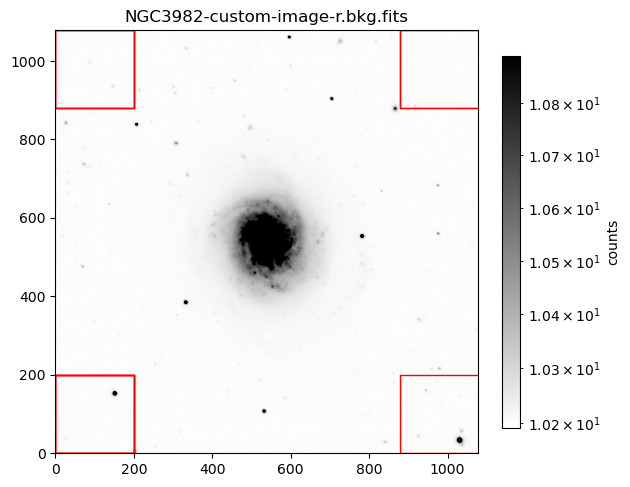

In [386]:
galname = 'NGC3982'
imname[galname] = 'NGC3982-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 200

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5198

5.3430326461792 5.763217258453368
image xdim =  1131 ; image ydim =  1131
mode =  5.3495049476623535
median =  5.349852085113525


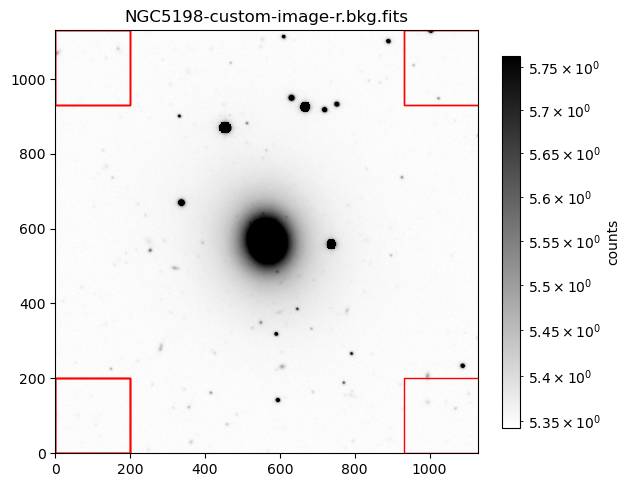

In [387]:
galname = 'NGC5198'
imname[galname] = 'NGC5198-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 200

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### NGC5985

22.116252899169922 22.362007522583006
image xdim =  2291 ; image ydim =  2291
mode =  22.122655868530273
median =  22.122758865356445


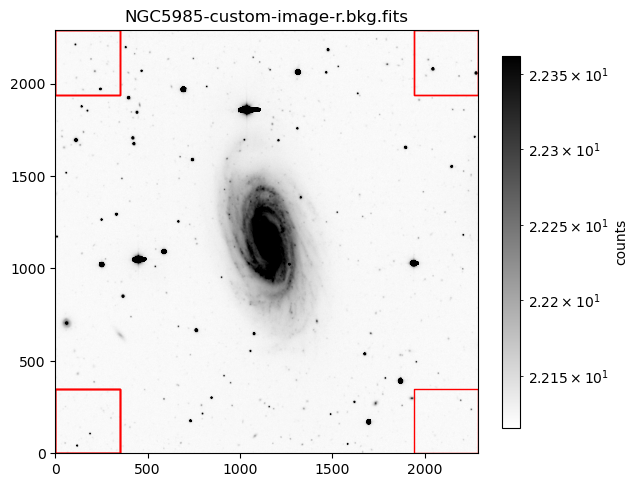

In [388]:
galname = 'NGC5985'
imname[galname] = 'NGC5985-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 350

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### PCG0997820

5.341621627807617 5.481662235260011
image xdim =  403 ; image ydim =  403
mode =  5.348475933074951
median =  5.350275993347168


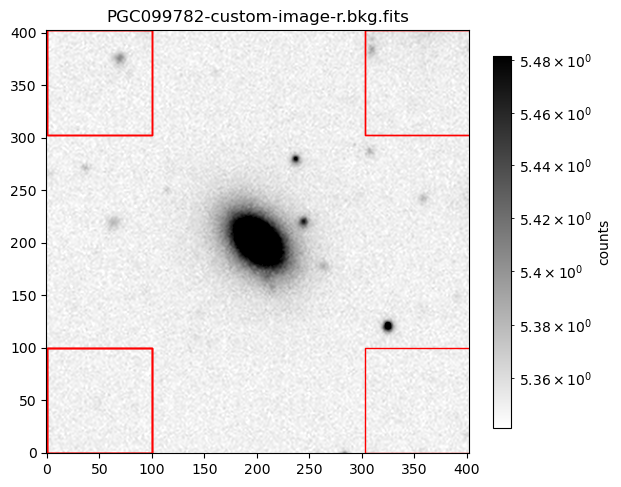

In [389]:
galname = 'PGC099782'
imname[galname] = 'PGC099782-custom-image-r.bkg.fits'
fig,ax = plt.subplots(figsize=(6,6))


data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 100

bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

#### 2. subtract background and display subtracted image

In this component you will need to:
* subtract your background from the previously read in image
* display that image
* write out your image

I provide one example below and you will need to do the other 3.  Note that since counts can be negative, you will need to choose v1perc to make sure that the lowest counts are positive.  The limits of the colorbar scale are printed after the imdisplay() command so you will see how far you are away.

In [390]:
#initializse dictionary that will hold background subtracted images
data_bsub = {}
imname_bsub = {}

### NGC 3982

8.296966552734375e-05 1.6422252273559677


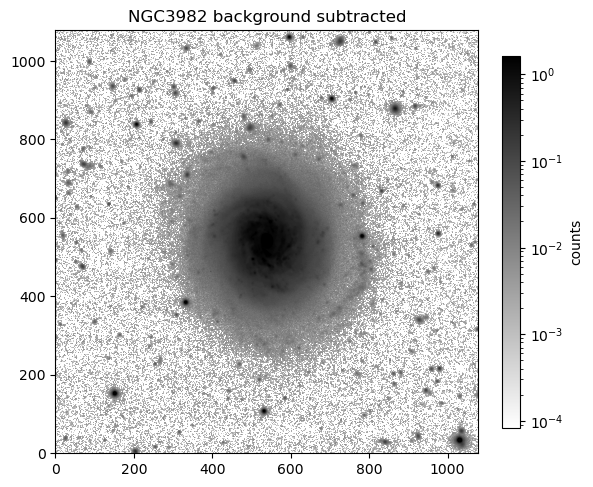

In [391]:
galname = 'NGC3982'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5198

0.0010209083557128906 10.000118255615234


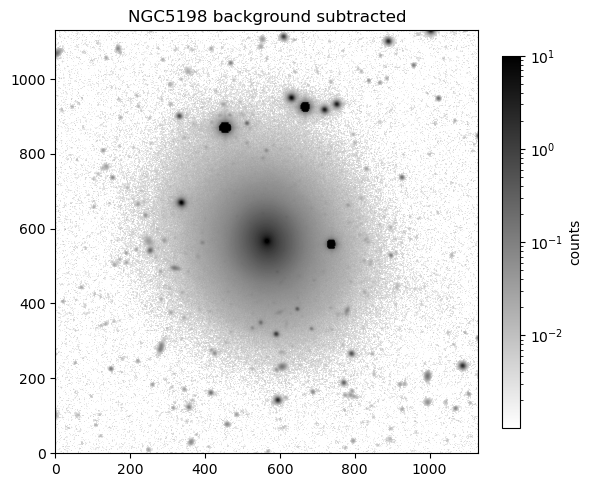

In [392]:
galname = 'NGC5198'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5985

0.000423431396484375 10.000223159790039


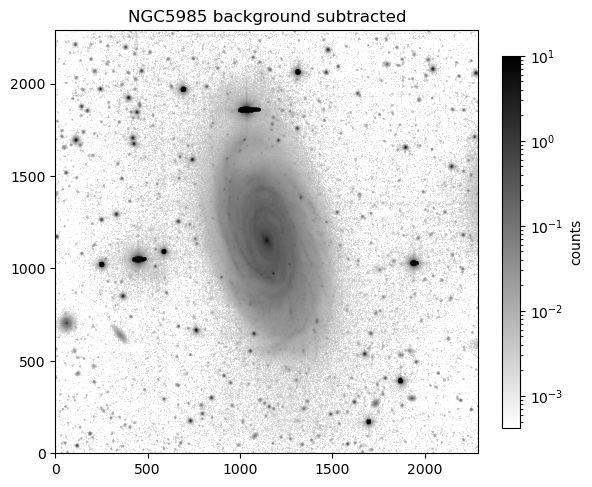

In [393]:
galname = 'NGC5985'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### PGC 0997820

0.0006132125854492188 0.6743682289123576


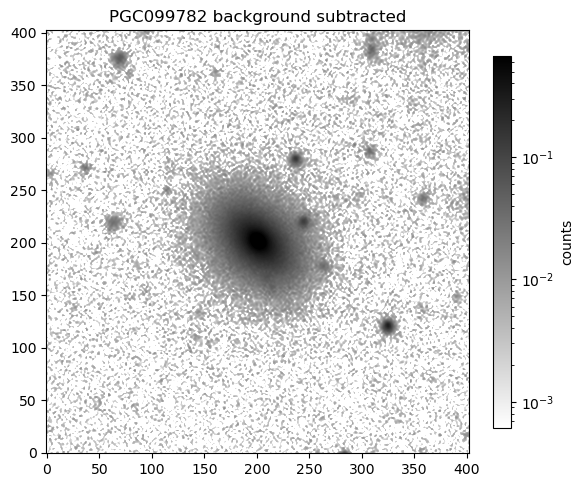

In [394]:
galname = 'PGC099782'

#subtract background
data_bsub[galname] = data[galname] - bkgmed[galname]

#plot image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=50,v2perc=99.9,logscale=True)
plt.title(galname + ' background subtracted')

# save the background_subtracted image
# first replace old string in name with new one
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")
#now write image
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

**Question**: comment on the differences between the images with background and those with background subtracted.  Please describe why you think this is.

There's less counts in the subtracted image because the removed background was adding onto the total amount of counts. There was almost a whole magnitude drop which meant that the background had a significant impact in what we were seein. After subtracting we are left with what hopefully is mostly the counts of the brighter objects. While talking about it with my friend Brady, we saw that the objects look more defined. This is also most likely due to the removal of the background/sound.

## Problem 2 - estimate initial guesses for ellipse parameters (15 Points)
The `photutils` package that we will be using for doing our photometry requires initial guesses for the center, semi-major axis, ellipticity, and position angle.  We will measure these using DS9.  
* xcen, ycen: What you think the center is by using the cursor on ds9

* semi-major axis, ellipticity, PA: For the other items you will need to make an elliptical region in ds9 that matches where the brighter part of the galaxy is.  If you double click on the region it will bring up a dialog box that lets you adjust the PA and also will output the semi-major and semi-minor axes, which you will need for the ellipticity measurement.  You should display the information in pixels using the dropdown to the right of the `radius` field in the "Ellipse" window.  Choose `Image`

**Note**: In ds9, when the first radius in the `Ellipse` window is the semi-major axis, the PA is measured South of East.  This is the same sense as the Elliptical Isophote package in the following problem uses.

For each galaxy, provide these intial guesses.  I will be storing these as a python dictionary for each galaxy.

These guesses do not need to be super precise but they need to be in the right ballpark.

In [395]:
#initialize the dictionary containing the intial parameters for the ellipse fitting
initparams = {}

#### NGC 3982

In [396]:
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC3982'
initparams[galname] = {}
initparams[galname]['xcen'] = 541
initparams[galname]['ycen'] = 541
initparams[galname]['sma'] = 96
initparams[galname]['ellip'] = 96./116.
initparams[galname]['PA'] = 90.0

#### NGC 5198

In [397]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5198'
initparams[galname] = {}
initparams[galname]['xcen'] = 570
initparams[galname]['ycen'] = 567
initparams[galname]['sma'] = 86 #Oringinal had issues plotting so I made the sma smaller by a factor of 1/2
initparams[galname]['ellip'] = 86./199.
initparams[galname]['PA'] = 10. + 90.

#### NGC 5985

In [398]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5985'
initparams[galname] = {}
initparams[galname]['xcen'] = 1166
initparams[galname]['ycen'] = 1133
initparams[galname]['sma'] = 292
initparams[galname]['ellip'] = 292./505.
initparams[galname]['PA'] = 12. + 90.

PGC 0997820

In [399]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'PGC099782'
initparams[galname] = {}
initparams[galname]['xcen'] = 202
initparams[galname]['ycen'] = 199
initparams[galname]['sma'] = 42.
initparams[galname]['ellip'] = 42./59.
initparams[galname]['PA'] = 215. + 90.

## Problem 3 - fit elliptical isophotes and measure the radial profiles for various ellipse paramters (15 Points)

We will now use the `photutils.isophot()` task to fit elliptical isophotes (https://photutils.readthedocs.io/en/stable/isophote.html).  An "isophote" is a line of constant surface brightness, akin to a countour on a topographical map.  To get a visual representation of an isophote do the following:
* open one of the background subtracted images in ds9 and dislay it in log scale
* in the analysis menu open "contour parameters" and set the number of countours to 10.  Then hit `Generate` and then `Apply`

The green lines on your image connect pixels of identical flux.  Since the pixels have the same area within a given image, these lines therefore connect points of constant surface brightness.

The `photutils.isophote()` code that we will be using fits ellipses to the isophotes.

In [400]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}

 We must provide the elliptical isophote fitter with an initial ellipse to be fitted. This ellipse geometry is defined with the **EllipseGeometry** class. Here we’ll define an initial ellipse from our answer to problem 2.

### NGC 3982

8.296966552734375e-05 1.6422252273559677


(<matplotlib.patches.Ellipse at 0x7fe7bc212a70>,)

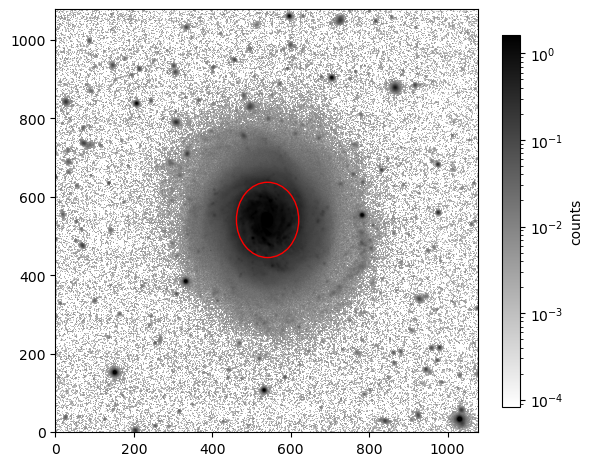

In [401]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC3982'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
aper.plot(color='red')

### NGC 5198

0.0010209083557128906 10.000118255615234


(<matplotlib.patches.Ellipse at 0x7fe7be967880>,)

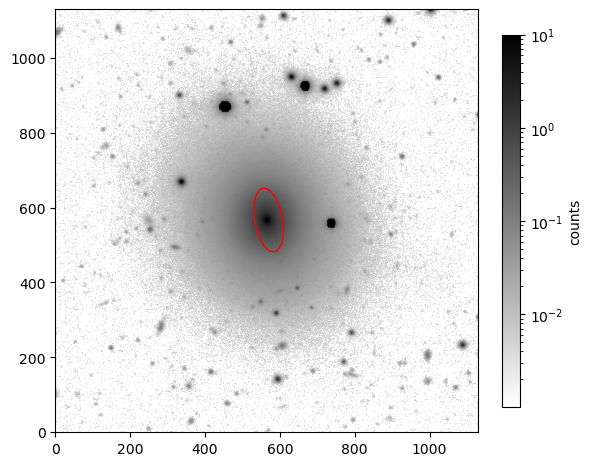

In [402]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5198'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
aper.plot(color='red')

### NGC 5985

0.000423431396484375 10.000223159790039


(<matplotlib.patches.Ellipse at 0x7fe7be707d90>,)

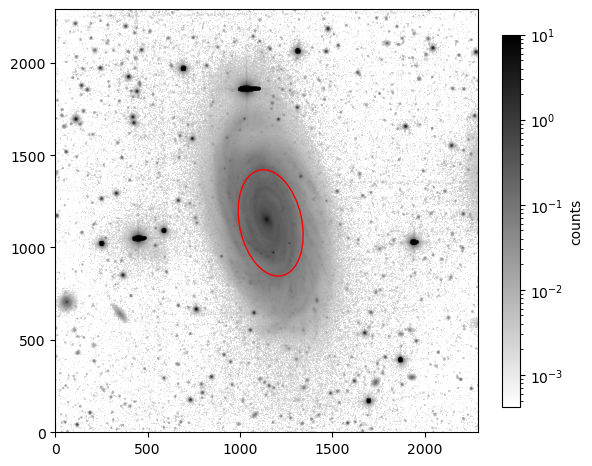

In [403]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5985'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)
aper.plot(color='red')


### PGC 0997820

0.0006132125854492188 0.6743682289123576


(<matplotlib.patches.Ellipse at 0x7fe7be6ea0b0>,)

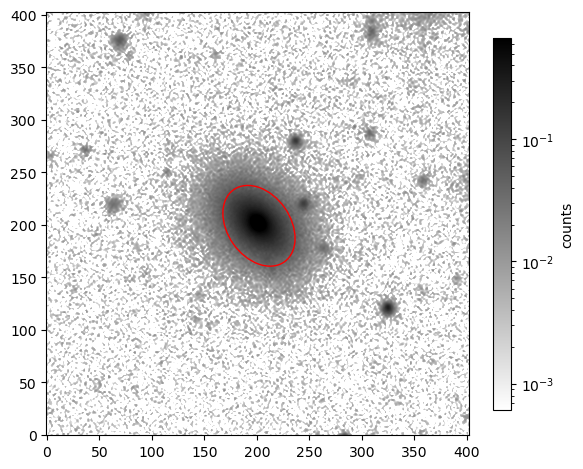

In [404]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'PGC099782'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (geometry[galname].eps), geometry[galname].pa)

#plot our image
fig,ax = plt.subplots(figsize=(6,6))
imdisplay(data_bsub[galname],v1perc=50,v2perc=99.9,logscale=True)
aper.plot(color='red')



make a subroutine to plot our outputs of ellipse fitting

In [405]:
def plotellipse(isolist):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

    #plot the semi-major axis vs. the ellipticity
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('Ellipticity')

    #plot the semi-major axis vs. the PA
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
                 yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('PA (deg)')

    #plot the semi-major axis vs. the x center of that ellipse
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('x0')

    #plot the semi-major axis vs. the y center of that ellipse
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('y0')

Next, we create an instance of the Ellipse class, inputting the data to be fitted and the initial ellipse geometry object:

In [406]:
from photutils.isophote import Ellipse

#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

The values computed by the fitting process are the attributes at this table https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html#photutils.isophote.Isophote

I will do the first galaxy for you and you will need to do the other three

### NGC 3982

In [407]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC3982'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0   13.573950953741187 ...     0         0
  0.50777761257742    13.41902604496207 ...    10         0
0.5585553738351621   13.396664110082979 ...    10         0
0.6144109112186783    13.37302688388951 ...    10         0
0.6758520023405461   13.317632646902677 ...    10         0
0.7434372025746008     13.1983546670543 ...    10         0
               ...                  ... ...   ...       ...
154.60896000000005  0.06403689979000197 ...    10         0
170.06985600000007  0.04052559163393898 ...    50         2
 187.0768416000001  0.02420955496801546 ...    50         2
205.78452576000012 0.016440212223330454 ...    50         2
226.36297833600014  0.01108956349496505 ...    50         2
248.99927616960017 0.007553276667398323 ...    14         5
 273.8992037865602 0.006733950435401152 

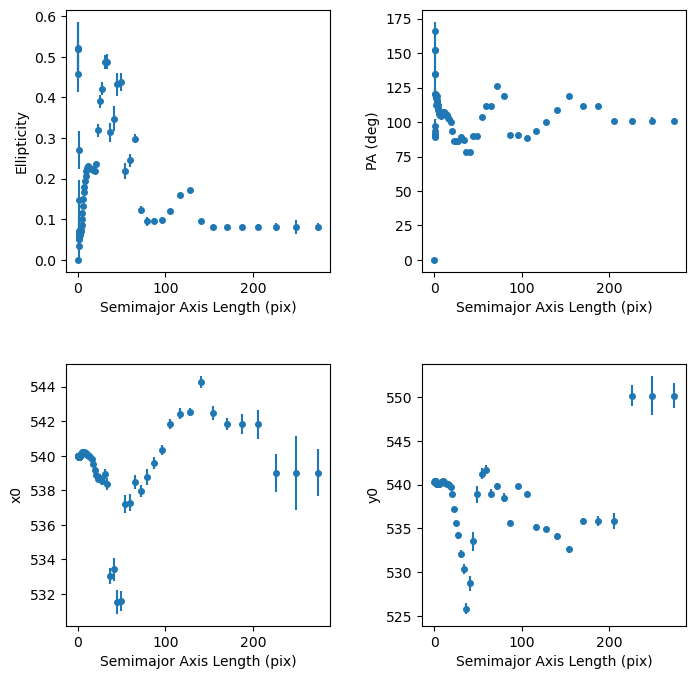

In [408]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

There is an expoential increase in the ellipiticity and then it trails. Since 0 pixels is your zero point, it makes sense that as you go farther from the center of the galaxy, the ellipiticity increased. If you look at the image, you can classify the galaxy an a sprial bar galaxy which could explain the bump around 40ish pix which would make it more elliptic at that point. For PA, there is a relatively consistent trend in the isophopte. If you zoom into the galaxy you can see small variations jutting out the center. The positionangle reflects such variation where the middle is not as circular until you go to the other edges of that center where it looks more ellipitical which can be explain by the consistentency after the initial exponential growth. This is also supported by the x and y graphs where as you go further out, the spirals around the center will cause bumps. These bumps aren't too significant because it's a few pixels but are noticible because mini spiral arms around the center.

### NGC 5198

In [409]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5198'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0   17.022792862088195 ...     0         0
0.5003725223939988   16.834529769044835 ...    11         0
0.5504097746333987   16.810395202656043 ...    10         0
0.6054507520967386    16.79378883626326 ...    10         0
0.6659958273064125    16.75442746299378 ...    10         0
0.7325954100370538   16.680354141421525 ...    10         0
               ...                  ... ...   ...       ...
152.35424600000007  0.05507774260772875 ...    10         0
 167.5896706000001  0.04408414800618321 ...     2         5
184.34863766000012 0.036087430678298345 ...    50         2
202.78350142600016  0.02782244523955504 ...    50         2
 223.0618515686002   0.0231264704543298 ...    50         2
245.36803672546023   0.0191874827346504 ...     5         5
 269.9048403980063  0.04931708096074045 

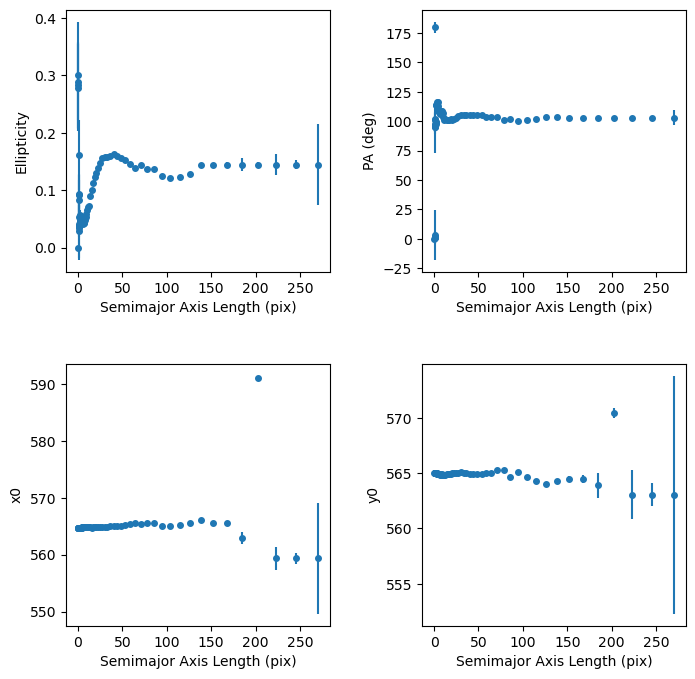

In [410]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

There is an expoential increase in the ellipiticity and then it trails. Since 0 pixels is your zero point, it makes sense that as you go farther from the center of the galaxy, the ellipiticity increased. The galaxy has very cirucular center. This is supported by the generally flat trend seen in the PA. As you go farther the less change there is. Of course there's going to be tiny changes but this is because nothing is a perfect shape. The way we create these isophotes assumes that the galaxy has is a perfect shape which is almost impossible to do. The X0 and Y0 plots also support this circular center because their change is relatively low. However the larger bars of error at the end seem like they almost increase linearly because you are measuring it more. I would imagine that the true value is close to that flat line because almost all of the point's error bars land within that flat trend.

### NGC 5985

In [430]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5985'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                intens        ... niter stop_code
                                        ...                
------------------ -------------------- ... ----- ---------
               0.0    6.425193302163529 ...     0         0
0.5413344063174018     6.33013125832188 ...    10         0
 0.595467846949142   6.3166262302299065 ...    10         0
0.6550146316440563    6.301850244715288 ...    10         0
0.7205160948084619    6.285658747622538 ...    10         0
0.7925677042893081     6.26738141239576 ...    10         0
               ...                  ... ...   ...       ...
388.65200000000016 0.049293121846217904 ...    10         0
427.51720000000023   0.0403681579608816 ...    10         0
470.26892000000026 0.028989661226936466 ...    50         2
 517.2958120000003  0.02134580472717716 ...    50         2
 569.0253932000004  0.01379539933595436 ...    50         2
 625.9279325200005 0.011581091611954164 ...    13         5
 688.5207257720006 0.005515647318701506 

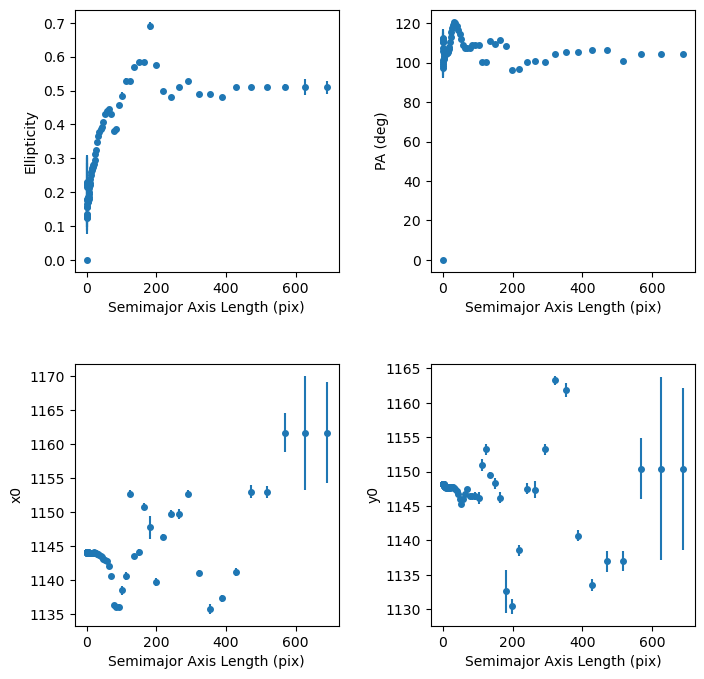

In [431]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

This galaxy seems to be on the extreme sides from the last two. NGC5985 is a spiral galaxy so it will have arms that spread out from the center. As we saw observed in the last two galaxies. The sprial arms do change the ellipicity which causes those spikes however since they're barely noticible, you can see the plot reflects that since after that bump, the change in ellipicity will become almost constant. The PA relfects the small center of the galaxy as well because even though from the larger portion of the center looks more uniform, the center looks more circular with the arms causing those small varaiatons. You can see that in the X0 and Y0 graphs, these arms have a large change around the ends of that center but will stable as you get past those huge changes in variation.

### PGC 0997820

In [416]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'PGC099782'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

       sma                 intens        ... niter stop_code
                                         ...                
------------------ --------------------- ... ----- ---------
               0.0    1.3566027212511866 ...     0         0
0.5238244589893085    1.3460432451628117 ...    10         0
0.5762069048882393    1.3441322067344028 ...    10         0
0.6338275953770632    1.3423883690301155 ...    10         0
0.6972103549147696    1.3409799023342812 ...    10         0
0.7669313904062466    1.3390156510342155 ...    50         2
               ...                   ... ...   ...       ...
55.902000000000015  0.020276285495853922 ...    10         0
 61.49220000000002  0.013988338458790142 ...    50         2
 67.64142000000002   0.01012129965424073 ...    50         2
 74.40556200000003  0.006647137584759369 ...    13         0
 81.84611820000003  0.004802577490339844 ...    50         2
 90.03073002000005  0.002975647877696226 ...    22         5
 99.03380302200006 0.001

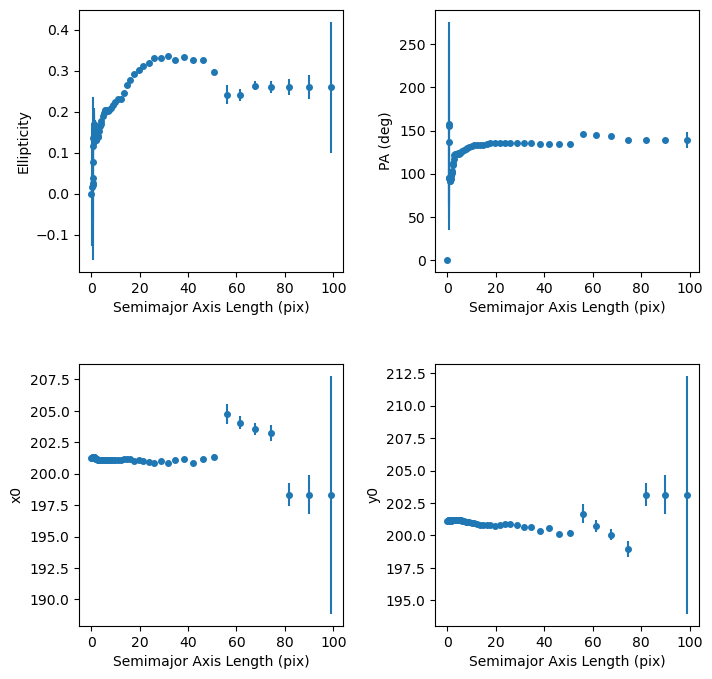

In [417]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].to_table())

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the image, as viewed in the cells above or in ds9

PGC 099782 is an elliptical galaxy so as expected teh ellipicity will follow an exponential growth as you out further and due to it's symmetry it will flatten out. The PA will also we consistent due to the same reason the ellipicity was the same. This can be supported by X0 and Y0 graphs being consistent. As we saw in the second, galaxy you can see that the trend is flat however as you go farther from the center it is harder to measure the PA which is why those points have a larger error.

## Problem 4 - measure the half light radius (15 points)

To do this we will create something called a "curve of growth", which shows how much light you get within each aperture.  As you increase in radius this cumulative flux grows.



In [432]:
#initialize dictionary for half-light radii
rhalfpix = {}
rhalfasec = {}

### NGC 3982

flux of largest isophote =  29365.27734375
{'NGC3982': 43.23000000000001}


Text(0.5, 1.0, 'NGC3982')

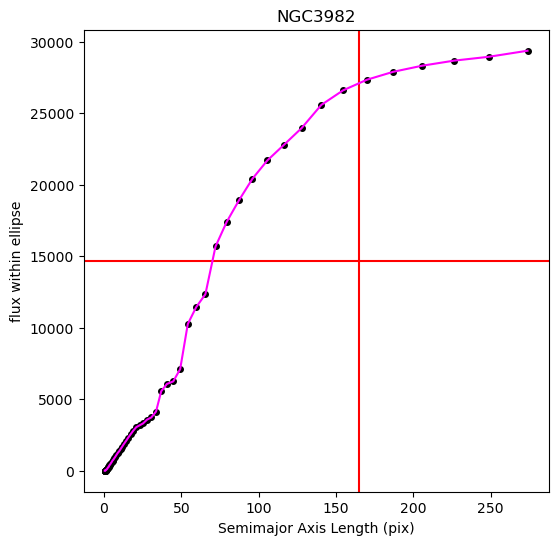

In [433]:
galname = 'NGC3982'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 165
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600
#fits.getdata(imname[galname],['CD2_2'], header=True)

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale
print (rhalfasec)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### NGC 5198

flux of largest isophote =  26042.748046875
{'NGC3982': 43.23000000000001, 'NGC5198': 31.44000000000001}


Text(0.5, 1.0, 'NGC5198')

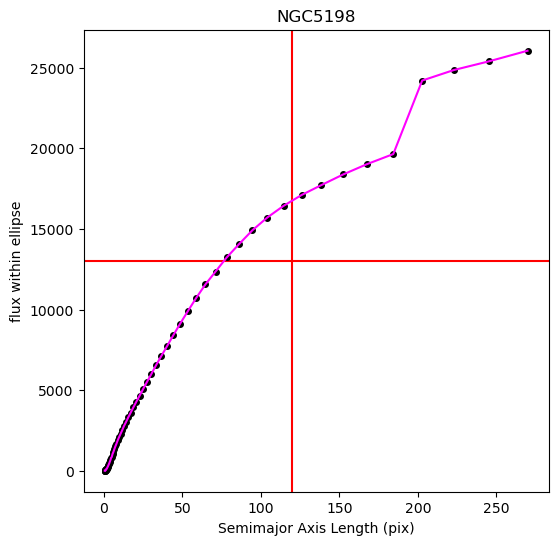

In [434]:
galname = 'NGC5198'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 120
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale
print (rhalfasec)

plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### NGC 5985

flux of largest isophote =  48090.2109375
{'NGC3982': 43.23000000000001, 'NGC5198': 31.44000000000001, 'NGC5985': 117.90000000000003}


Text(0.5, 1.0, 'NGC5985')

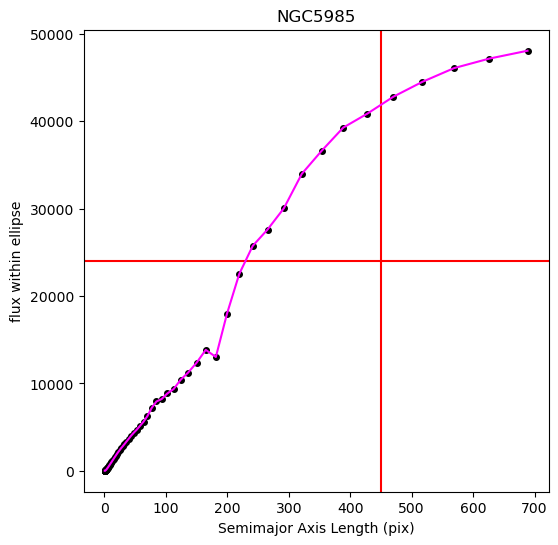

In [435]:
galname = 'NGC5985'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 450
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600 

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale
print (rhalfasec)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


### PGC 0997820

flux of largest isophote =  910.9540405273438
{'NGC3982': 43.23000000000001, 'NGC5198': 31.44000000000001, 'NGC5985': 117.90000000000003, 'PGC099782': 17.030000000000005}


Text(0.5, 1.0, 'PGC099782')

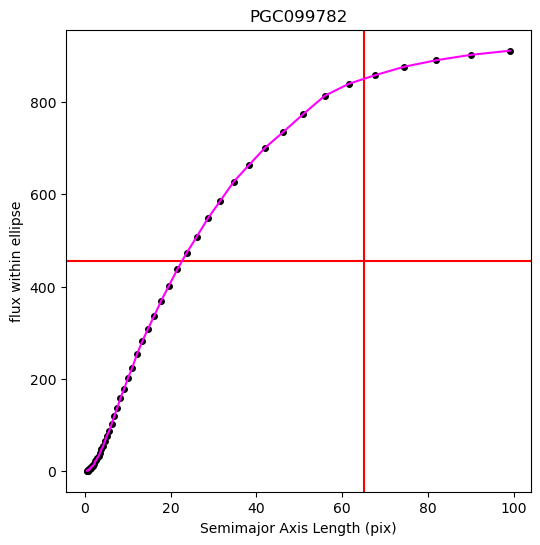

In [436]:
galname = 'PGC099782'
plt.figure(figsize=(6, 6))

#plot the semi-major axis vs. the total flux within that ellipse.
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='o', markersize=4, color='black')
plt.errorbar(isolist[galname].sma, isolist[galname].tflux_e, 
             fmt='-', markersize=4, color='magenta')

#the flux of the last array element
print('flux of largest isophote = ', isolist[galname].tflux_e[-1])

#a horizontal line at half the total flux
plt.axhline(isolist[galname].tflux_e[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
rhalfpix[galname] = 65
plt.axvline(rhalfpix[galname], color='red')

#***************************
#Your code here
#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600 

#***************************
#convert the half-light radius from pixels to arcsec
#provide the expression to do this and print it
rhalfasec[galname] = rhalfpix[galname] * pixscale
print (rhalfasec)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('flux within ellipse')
plt.title(galname)


**Question** For the galaxies above, answer in words written below each bullet:
* For each galaxy how the half-light compares to the visible extent of the galaxy using what you see in the displayed images or in ds9?

* For each galaxy, which feature of the curve of growth tells you whether you can establish well what the maximum flux is?

* For each galaxy, use imexam to measure the FWHM of the image using stars in the image.  Then quantify how your half-light radius for each galaxy compares to the FWHM.  

**Question** If the goal of measuring the half-light radius is to obtain light from the galaxy.  What do you think you can do in order to minimize the effect of other sources in the image on this measurment.  

For NGC 3982, you can see that the brightest portion of the galaxy lies around the 100 - 150 pixel range which is about what the isophote dimensions were. You can see that the galaxy extends another 200 pixels on either sides of the isophote. The half light value of 165 supports that as you can see there's more around the center of the galaxy. This is also factually true because in this type of galaxy, the center will be the brightest spot. There is a spot in the graph where it seems to flatten which usually indicate that not as much light is being observed in those pixels which is consistent that the center is brighter. As you go further out from the center, you'll start to see counts that still remain due to foreground/background objects such as the other stars. When using imexam, you can see that FWHM of a star in the background is about 5 which is significantly smaller than the half light ratio.

For NGC 5198, it's a bit difficult to see how far the galaxy extends but I estimate that it extends around 200 pixels and my halflight value of 120 is very off however it is because of how I tried to place that value on the plot. You can see that there is a large spike in 180 - 210 range but as you can see in the image, there is about 3 bright objects on what I consider the galaxy that cause the sudden jump. Removing those objects would help move that half value closer to the right makeing that value larger. Picking a random star in the image, the FWHM value for that star is about 5 which again is significantly smaller than the halflife ratio value.

For NGC 5985 you can see that the center (again not suprisingly the brightest) sits around a radius of about 500 pixels. The chosen half light value of 450 is close enough. This might be wrong because of the galaxy's spiral arm which will see increase and decrease in brightness as you jumped between the arms. If you were to determine that just using the curve, it starts to plateau around the 600 mark. However since the two values are similar enough you can determine that the maximum flux lies around those two values. Using imexam, a random star's FWHM is about 5.6 which again proves that the galaxy is much brighter in this image.

For PGC 099782, you can observe that the galaxy is brightest around it's center despite being spread out. The half max of 65 tends to fall within that range of what you can see of the galaxy. You can see that curve stars to plataue around after 60 which is about what I placed my half light value at. I feel that the maximum flux actually lies somewhere around 90 because that is when it really starts to flatten out. When comaring the half light ratio to a star, you can see the the FWHM value of the star (6) is significantly smaller.

I think that the best way to minimize the effects of other sources is to change the amount we consider from each filter. We perform operations on the image where we give more weight to the counts given in the bands where other objects are the least bright in.

## Problem 5 - construct radial surface brightness profiles (15 Points)

In this problem you will construct radial surface brightness profiles of each galaxy and use them to infer the central surface brightness and that at the half-light radius.

For the purpose of these plots, we will fix the ellipticity and position angle at the values determined at the half-light radius.

You will need to:
* measure mean surface brightness in mag/asec^2 in each annulus
* calculate its uncertainty
* plot the surface brightness profile
* determine the surface brightness at the half-light radius

In [437]:
from photutils.aperture import ApertureStats
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

### NGC 3982

The radius ceneter is 0.8950113520754166
The SB at the center is 17.176709949729652
The surface brightness at the effective radius is: 20.34095058087582
flux_SB(rhalf) / flux_SB(rcent) = 0.054


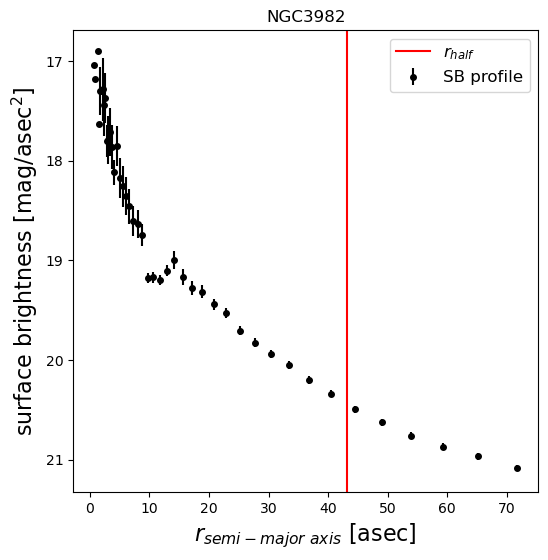

In [438]:
galname = 'NGC3982'

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
fcent = np.array([]) #Lets just do the same thing to get the center of the other ones.
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area

        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, (2.5/(avflux*np.log(10)))*avflux_err) #propagation of error
        fcent = np.append(fcent, avflux/ pixarea)

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
x = rcent[20] #Grab the value from the array above
y = sbcent[20]
print('The radius ceneter is', x)
print('The SB at the center is', y)
#calculate print out the surface brightness at the effective radius
#***********************
#your code here
x = rcent[60]
y = sbcent[60] 
print('The closest distance to the effective radius is:', x)
print('The surface brightness at the effective radius is:', y)
#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = fcent[60]/fcent[20]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


### NGC 5198

The radius ceneter is 0.8819591031909827
The SB at the center is 16.815920003031493
The surface brightness at the effective radius is: 20.70647426715317
flux_SB(rhalf) / flux_SB(rcent) = 0.028


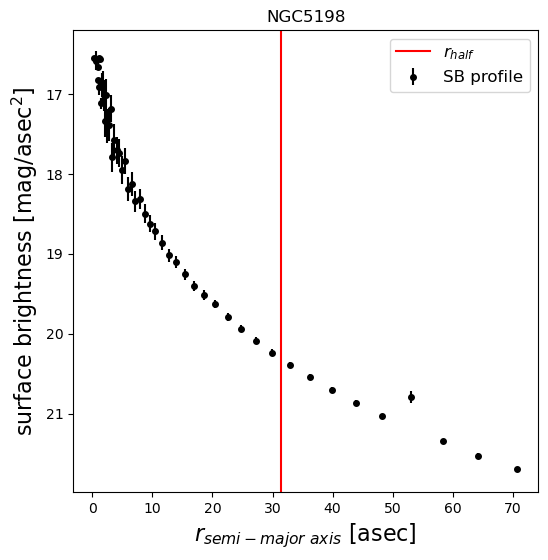

In [439]:
galname = 'NGC5198'
#***************
#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
fcent = np.array([]) #Lets just do the same thing to get the center of the other ones.
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area

        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, (2.5/(avflux*np.log(10)))*avflux_err) #propagation of error
        fcent = np.append(fcent, avflux/ pixarea)

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
x = rcent[20] #Grab the value from the array above
y = sbcent[20]
print('The radius ceneter is', x)
print('The SB at the center is', y)
#calculate print out the surface brightness at the effective radius
#***********************
#your code here
x = rcent[60]
y = sbcent[60]
print('The closest distance to the effective radius is:', x) 
print('The surface brightness at the effective radius is:', y)
#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = fcent[60]/fcent[20]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


### NGC 5985

The radius ceneter is 0.9541587240599542
The SB at the center is 17.777669862782894
The surface brightness at the effective radius is: 21.232917164244196
flux_SB(rhalf) / flux_SB(rcent) = 0.041


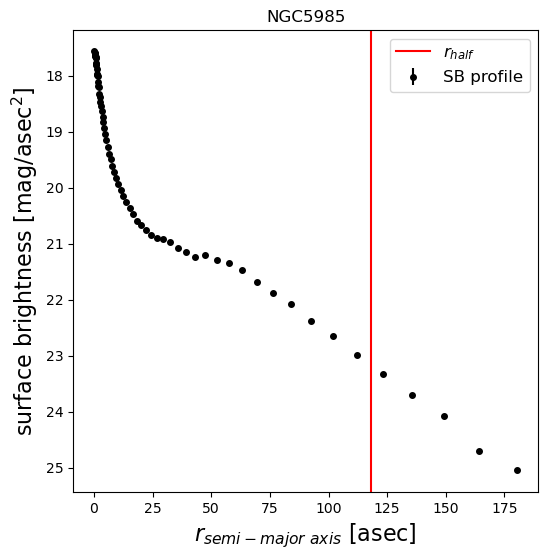

In [440]:
galname = 'NGC5985'

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
fcent = np.array([]) #Lets just do the same thing to get the center of the other ones.
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area

        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp)
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, (2.5/(avflux*np.log(10)))*avflux_err) #propagation of error
        fcent = np.append(fcent, avflux/ pixarea)

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
x = rcent[20] #Grab the value from the array above
y = sbcent[20]
print('The radius ceneter is', x)
print('The SB at the center is', y)
#calculate print out the surface brightness at the effective radius
#***********************
#your code here
x = rcent[60]
y = sbcent[60]
print('The closest distance to the effective radius is:', x) 
print('The surface brightness at the effective radius is:', y)
#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = fcent[60]/fcent[20]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')

### PGC 0997820

The radius ceneter is 0.9232956035821948
The SB at the center is nan
The surface brightness at the effective radius is: 22.555517024003166
flux_SB(rhalf) / flux_SB(rcent) = nan


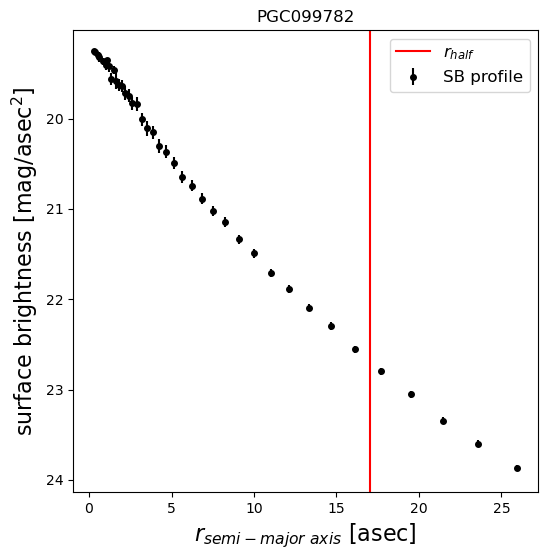

In [443]:
galname = 'PGC099782'

#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = isolist[galname].sma - rhalfpix[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfpixind = np.argmin(abs(diff))

#print(rhalfpix[galname],isolist[galname].sma[rhalfpixind])

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
fcent = np.array([]) #Lets just do the same thing to get the center of the other ones.
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * isolist[galname].eps[rhalfpixind]
        b_in = a_in * isolist[galname].eps[rhalfpixind]

        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((isolist[galname].x0[aindx],isolist[galname].y0[aindx]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = isolist[galname].pa[rhalfpixind])
        aperstats = ApertureStats(data_bsub[galname],annulus_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats.std
        #the number of pixels in each annulus
        numpix = aperstats.sum_aper_area

        #****************************
        #your code here
        #the area of a pixel
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        sbcent = np.append(sbcent, -2.5 * np.log10(avflux/pixarea) + magzp) 
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        avflux_err = stdflux/np.sqrt(numpix)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, (2.5/(avflux*np.log(10)))*avflux_err) #propagation of error
        fcent = np.append(fcent, avflux/ pixarea)

fig,ax = plt.subplots(figsize=(6, 6))

#plot the semi-major axis vs. magnitude
ax.errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax.invert_yaxis()

plt.axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax.legend(fontsize=12)

ax.set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax.set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
plt.title(galname)

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
x = rcent[20] #Grab the value from the array above
y = sbcent[20]
print('The radius ceneter is', x)
print('The SB at the center is', y)
#calculate print out the surface brightness at the effective radius
#***********************
#your code here
x = rcent[50]
y = sbcent[50]
print('The closest distance to the effective radius is:', x) 
print('The surface brightness at the effective radius is:', y)
#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here
flux_rat = fcent[50]/fcent[20]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


**Question** Describe the ratio in surface brightness between the center and outskirts including the following points:
* Are there differences between ellipticals and spirals?
* Does the degree to which your galaxy is well resolved matter?
* Does the behavior of the light profile differ inside and outside of the half-light radius?  
* which galaxies have light profiles consistent with being exponential, and in what part of the profiles

**answer goes here**

Looking at the slides, I could make the safe assumption to believe that NGC 3982 and NGC 5985 are spiral galaxies. The reason why is that spiral galaxies will show a sircuis profile of an exponential decay which can be seen in those two galaxies and you can see the bumps created by the spiral arms. You can see that the other two ellipticals follow a more linear trend.

It is important to have good resolution because the brightness can vary as observed in the galaxies. So if you can't tell that there's arms in a galaxy, you'll just assume it's an elliptical which will make it follow an inaccurate linear trend.

The behavior of the light profile will have a consistent trend with the half-light radius, however beyond that, you can expect to see a devation which depending on the resoltution and galaxy, it will deviate more. My friend Brady observed that difference of deviation was noticible with PGC 0997820 having a smaller devation compared to the spiral galaxies and that the greatest deviation would come from NGC5985 because of it's low resolution.

As mentioned before the galaxies that follow an exponential trend are NGC 3982 and NGC 5985 because they're spiral galaxies. You can tell that surface brightness decay consistent around the center of the galaxy which would agree with the fact that the galaxy is most brightest around the center of the galaxy with the bumps caused yet again by the spiral arms.
